In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

## General classes

In [22]:
class Environment:
    def __init__(self):
        pass

    def round(self, product_price):
        pass

In [23]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass

### Requirement 1: single product and stochastic environment

#### Environment

In [24]:
class SingleProductEnvironment(Environment):
  def __init__(self, T, valuation_distr=stats.uniform):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = valuation_distr.rvs(size=T)

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

#### Agent without inventory constraint - UCB1

In [25]:
class UCB1(Agent):
    def __init__(self, T, prices, range=1):
        self.range = range # Range of the reward
        self.P = len(prices) # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)
            
            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

#### Clairvoyant without inventory constraint

In [26]:
class SingleProductStochasticClairvoyant:
    def __init__(self, T, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [ ]:
# Parameters
T = 5000

# Prices
max_price = 150
price_step = 5
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 150
valuation_distr = stats.binom(loc=0, n=max_valuation, p=0.5)

In [ ]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 1
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, valuation_distr)
  ucb_like_agent = UCB1(T, prices, range=max_price)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)

  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

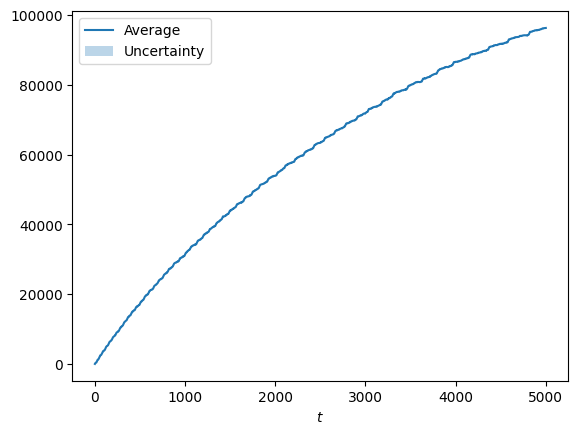

In [50]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T), 
    average_regret-regret_sd/np.sqrt(n_trials), 
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

#### Agent with inventory constraint - UCB-like

In [97]:
class UCBLike():
    def __init__(self, T, B, prices, range=1):
        self.T = T
        self.P = len(prices)
        self.range = range

        self.pi_t = None
        self.avg_f = np.zeros(self.P)
        self.avg_c = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)
        self.budget = B

        self.t = 0
    
    def pull_arm(self): 
        # Check if budget is depleted
        if self.budget < 1:
            self.pi_t = 0
            return 0
        
        if self.t < self.P:
            self.pi_t = self.t 
        else:
            # Upper Confidence Bound
            f_ucbs = self.avg_f + self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Lower Confidence Bound 
            c_lcbs = self.avg_c - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls)

            # Price optimal distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)

            # Set current price
            self.pi_t = np.random.choice(self.P, p=gamma_t)

        return self.pi_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        
        c = -f_ucbs

        A_ub = [c_lcbs]
        rho = self.budget/(T)
        b_ub = [rho]

        A_eq = [np.ones(self.P)]
        b_eq = [1]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        
        gamma = res.x
        return gamma
    
    def update(self, f_t, c_t):
        # Update the number of pulled price
        self.N_pulls[self.pi_t] += 1

        # Update averages
        self.avg_f[self.pi_t] = self.avg_f[self.pi_t] + (f_t - self.avg_f[self.pi_t])/self.N_pulls[self.pi_t]
        self.avg_c[self.pi_t] = self.avg_c[self.pi_t] + (c_t - self.avg_c[self.pi_t])/self.N_pulls[self.pi_t]

        # Update budget
        self.budget = self.budget - c_t

        self.t += 1

#### Clairvoyant with inventory constraint

In [ ]:
class SingleProductStochasticInventoryClaivoyant:
    def __init__(self, T, B, prices, valuation_distr=stats.uniform):
        self.T = T
        self.prices = prices

        # This is probability distributions over valuations (scipy.stats)
        self.valuation_distr = valuation_distr

    def run(self):
        # Probability of selling a product
        selling_prob = 1 - self.valuation_distr.cdf(self.prices)

        ## Liner programming
        c = - self.prices * selling_prob # objective function coefficients

        # Constraints
        A_eq = [np.ones(len(self.prices))]
        b_eq = [1]

        # Resolve LP
        res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

#### Evaluation

In [118]:
# Parameters
T = 500
B = 500

# Prices
max_price = 150
price_step = 5
prices = np.arange(0, max_price, price_step)

# Valuation prob. distribution
max_valuation = 150
valuation_distr = stats.binom(loc=0, n=max_valuation, p=0.5)

In [119]:
# Run clairvoyant
clairvoyant = SingleProductStochasticClairvoyant(T, prices, valuation_distr)
expected_clairvoyant_utilities = clairvoyant.run()

n_trials = 1
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, valuation_distr)
  ucb_like_agent = UCBLike(T, B, prices, range=max_price)

  agent_rewards = []
  for t in range(T):
    # This returns the price index
    pi_t = ucb_like_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb_like_agent.update(r_t, r_t > 0)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

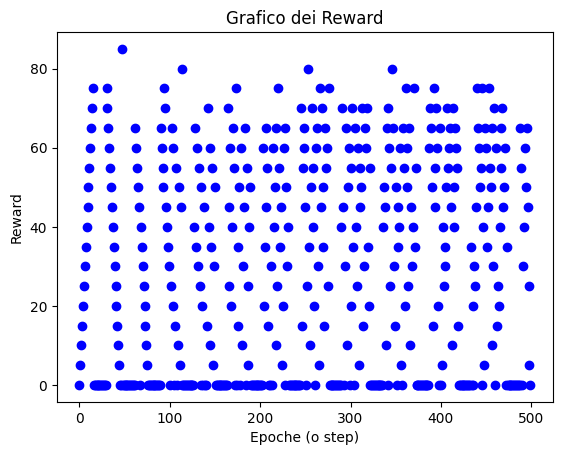

In [120]:
# Crea il grafico
plt.scatter(np.arange(T),agent_rewards, marker='o', linestyle='-', color='b')

# Aggiungi titolo e etichette agli assi
plt.title("Grafico dei Reward")
plt.xlabel("Epoche (o step)")
plt.ylabel("Reward")

# Mostra il grafico
plt.show()

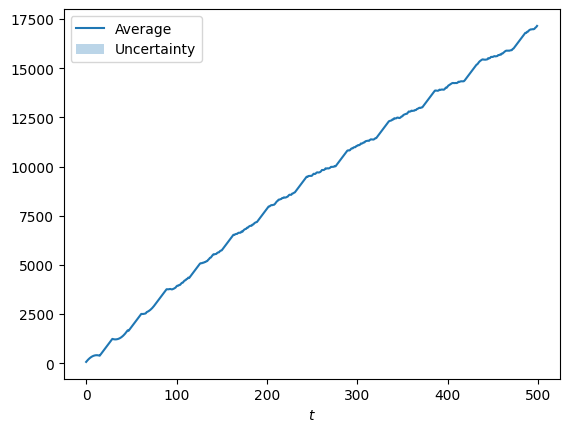

In [121]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T), 
    average_regret-regret_sd/np.sqrt(n_trials), 
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

### Requirement 2: multiple products and stochastic environment

In [ ]:
class MultipleProductEnvironment(Environment):
  def __init__(self, T, N, max_valuation):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    # Valuation of each buyer sampled from the given distribution function
    self.valuations = np.random.uniform(0, max_valuation, size=(T, N))

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Requirement 3: best-of-both-worlds algorithms with a single product

### Requirement 4: best-of-both-worlds algorithms with multiple products

### Requirement 5: slightly non-stationary environments with multiple products